# MI-MVI tutorial 2 #

In the first tutorial, we introduced you to **Tensorflow**, a Deep Learning framework. You learned how to **define a computation graph**, and **create and initialize a Session**. Finally, you trained a simple classification model on a dataset of digits called **MNIST**.

In this tutorial, we will experiments with various methods for the training of neural networks. Furthermore, we will show you how to use some advanced Tensorflow features like saving and loading models as well as visualizing the training. Lastly, we will learn how to regularize a neural network.

We thank the authors of this [Udacity tutorial](https://github.com/tensorflow/tensorflow/tree/master/tensorflow/examples/udacity) which was the main inspiration for this tutorial. We have reused some of their code snippets.

## Part 1: the notMNIST dataset ##

![notMNIST example](images/notMNIST.png)

The [notMNIST dataset](http://yaroslavvb.blogspot.cz/2011/09/notmnist-dataset.html) created by [Yaroslav Bulatov](https://www.blogger.com/profile/06139256691290554110) contains pictures of **letters from A - J** gathered from a multitude of publicly available fonts. The letters are in the same fromat as MNIST - 28x28 grayscale pictures. The dataset is harder than MNIST but small enough to be used on a laptop making it a perfect dataset for small-scale experiments.

We will work only with letters A - D in order for our experiments to run faster. You can use *cv2-notmnist-prepare-data* to load all letters (you will need to make some changes) if you want to experiment with the whole dataset.

Download the preprocessed dataset from [this](https://drive.google.com/file/d/1FE7thwYRktH-D8wi_4dYXsGPNG_Qno10/view?usp=sharing) link and place it in the **data/notMNIST** directory. Alternatively, you can download and preprocess the dataset using the *cv2-notmnist-prepare-data* notebook.

**Import** Python modules we will use.

In [1]:
import os, pickle
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

/home/martilad/FIT/MI-MVI2019/__venv__/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/martilad/FIT/MI-MVI2019/__venv__/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/martilad/FIT/MI-MVI2019/__venv__/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/martilad/FIT/MI-MVI2019/__ve

You should have the preprocessed subset of notMNIST saved as a [pickle](). You can use the code snippet below to **load** it any time.

In [2]:
# load a subset of the notMNIST dataset
data_root = 'data/notMNIST'
pickle_file = os.path.join(data_root, 'notMNIST.pickle')

with open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  train_dataset = save['train_dataset']
  train_labels = save['train_labels']
  valid_dataset = save['valid_dataset']
  valid_labels = save['valid_labels']
  test_dataset = save['test_dataset']
  test_labels = save['test_labels']
  labels = save['labels']

  del save  # hint to help gc free up memory
  print('Training set', train_dataset.shape, train_labels.shape)
  print('Validation set', valid_dataset.shape, valid_labels.shape)
  print('Test set', test_dataset.shape, test_labels.shape)

Training set (18000, 28, 28) (18000,)
Validation set (1000, 28, 28) (1000,)
Test set (1000, 28, 28) (1000,)


**Display** a couple of images so that we know what we are working with. If possible, always visualize your data preprocessing pipeline in order to spot bugs.

run again for different images
B
B
C
A


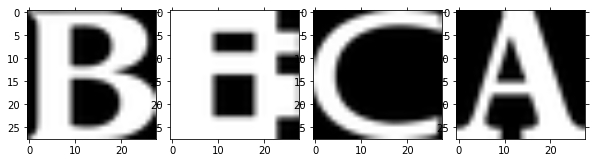

In [4]:
print("run again for different images")

from mpl_toolkits.axes_grid1 import ImageGrid

fig = plt.figure(1, figsize=(10, 10))
grid = ImageGrid(fig, 111, nrows_ncols=(1, 4), axes_pad=0.2)

for i in range(4):
    index = np.random.randint(0, train_dataset.shape[0])
    
    grid[i].imshow(train_dataset[index] / 255, interpolation="bilinear", cmap="gray")
    grid[i].tick_params(axis='both', which='both', bottom='off', top='off', 
                    labelbottom='off', right='off', left='off', labelleft='off')

    for key, value in labels.items():
        if value == train_labels[index]:
            print(key)
    
plt.show()

The individual pixels are encoded as grayscale values with integers in the range [0-255]. To help the classfier to converge, we **normalize** images so that they have zero mean and unit variance. 

**(Optional) Task**: Try skipping the normalization step or only subtracting means and see how it impacts the final performance (if the model trains at all).

In [5]:
mean = np.mean(train_dataset, axis=0)
std = np.std(train_dataset, axis=0)

train_dataset = (train_dataset - mean) / std
valid_dataset = (valid_dataset - mean) / std
test_dataset = (test_dataset - mean) / std

Notice that we compute means and standard deviations over the training set. As expected, the training set has zero mean and unit variance after normalization. However, the means and variances of the validation and testing set slightly deviate. 

**Question**: Why do we use means and standard deviations computed over the training set to normalize the validation and testing sets?

*Hint: generalization*.

In [6]:
print("statistics after normalization")
print("training mean:", np.round(np.mean(train_dataset), 5), ", variance:", 
                        np.round(np.var(train_dataset), 5))
print("validation mean:", np.round(np.mean(valid_dataset), 5), ", variance:", 
                          np.round(np.var(valid_dataset), 5))
print("testing mean:", np.round(np.mean(test_dataset), 5), ", variance:", 
                       np.round(np.var(test_dataset), 5))

statistics after normalization
training mean: 0.0 , variance: 1.0
validation mean: 0.00127 , variance: 0.99529
testing mean: 0.01194 , variance: 0.99847


**Shuffle** the pictures to make sure that each mini-batch is an **unbiased sample** of the training data.

In [7]:
# https://stackoverflow.com/questions/4601373/better-way-to-shuffle-two-numpy-arrays-in-unison
def unison_shuffle(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

In [8]:
train_dataset, train_labels = unison_shuffle(train_dataset, train_labels)
valid_dataset, valid_labels = unison_shuffle(valid_dataset, valid_labels)
test_dataset, test_labels = unison_shuffle(test_dataset, test_labels)

## Part 2: Building a classification model ##

In this section, we will build a **neural network** for letter classification and train it with **batch gradient descent**, **stochastic gradient descent** and **mini-batch gradient descent**.

The dataset stores each image as a Tensor of rank two (width x height). However, a fully-connected (standard) neural network only accepts vectors (Tensors of rank 1). Therefore, the following cell **vectorizes each image in the dataset**.

![flatten image](images/flatten_image.png)

In [9]:
# vectorize each image
def maybe_vectorize(dataset):
  if len(dataset.shape) == 3:
    return np.reshape(dataset, (dataset.shape[0], dataset.shape[1] * dataset.shape[2]))
  else:
    return dataset

train_dataset = maybe_vectorize(train_dataset)
valid_dataset = maybe_vectorize(valid_dataset)
test_dataset = maybe_vectorize(test_dataset)

print('Training dataset shape:', train_dataset.shape)
print('Validation dataset shape:', valid_dataset.shape)
print('Test dataset shape:', test_dataset.shape)

Training dataset shape: (18000, 784)
Validation dataset shape: (1000, 784)
Test dataset shape: (1000, 784)


Furthermore, the dataset labels (which record what letter is depicted on each image) are stores as integers where 0 represents letter A and 3 represents D. A neural network usually outputs a vector in which each element represents the probability that an input image belongs to a certain label. In order to train the neural network, you will need to compare the predicted probabilities with the correct label. To do this, it's convenient to turn each label into a vector with a one in the position that corresponds to its index and the rest set to zero. This is called **one-hot encoding**.

![one-hot encoding](images/one_hot_encoding.jpg)

In [10]:
# one-hot encode each label
def maybe_turn_to_one_hot(labels, num_labels=4):
  if len(labels.shape) == 1:
    one_hot = np.zeros((labels.shape[0], num_labels))
    one_hot[np.arange(len(labels)), labels] = 1
    return one_hot
  else:
    return labels

train_labels = maybe_turn_to_one_hot(train_labels)
valid_labels = maybe_turn_to_one_hot(valid_labels)
test_labels = maybe_turn_to_one_hot(test_labels)

print('Training labels shape:', train_labels.shape)
print('Validation labels shape:', valid_labels.shape)
print('Test labels shape:', test_labels.shape)

Training labels shape: (18000, 4)
Validation labels shape: (1000, 4)
Test labels shape: (1000, 4)


### Fully-connected Neural Network ###

In the following series of tasks, you will implement a classfication model from scratch. We recommend you to use the Jupyter notebook from the first tutorial as a reference and try to implement your model based on that. Alternatively, you check the reference notebook which has all the solution (except for Part 4 which contains a bonus-point task) but you won't learn much by copying them. The tasks aren't graded.

### Task 1A ###

* define a computation graph for a **fully-connected neural network**
* the network should have **2 hidden layers** with **200 neurons in the first** and **100 neurons in the second** hidden layer
* **input**: vectorized images in the shape (num_images, 784)
* **output**: predictions in the shape (num_images, 4)

See the reference notebook for a solution.

In [11]:
import tensorflow as tf
tf.reset_default_graph()   # TF remembers everything you defined, this will keep the computation graph clean

#learning_rate = 0.1              # Batch Gradient Descent
#learning_rate = 0.01             # Stochastic Gradient Descent
learning_rate = 0.05            # Mini-batch Gradient Descent

input_data = tf.placeholder(tf.float32, (None, train_dataset.shape[1]))
input_labels = tf.placeholder(tf.int32, (None, train_labels.shape[1]))

layer1 = tf.layers.dense(input_data, 200, activation=tf.nn.relu)
layer2 = tf.layers.dense(layer1, 100, activation=tf.nn.relu)
logits = tf.layers.dense(layer2, 4)

batch_loss = tf.nn.softmax_cross_entropy_with_logits(labels=input_labels, logits=logits)
loss = tf.reduce_mean(batch_loss)
train_op = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)

accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(logits, 1), tf.argmax(input_labels, 1)), tf.float32))

Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



### Task 1B ###

* train the neural network you defined above using **Batch Gradient Descent**
* during each learning step, the network makes predictions for all 18000 training images and learns from its mistakes
* evaluate the network on the notMNIST evaluation set


* recommended learning rate: 0.1
* recommended number of training steps: 60

See the reference notebook for a solution.

In [13]:
num_steps = 60

with tf.Session() as session:
  session.run(tf.global_variables_initializer())

  for step in range(num_steps):
    batch_loss, batch_accuracy, _ = session.run([loss, accuracy, train_op], feed_dict={
      input_data: train_dataset,
      input_labels: train_labels
    })
    print('step:', step, ', loss:', batch_loss, ', training accuracy:', batch_accuracy)
    
  print('Training finished after', num_steps, 'steps.')
  validation_accuracy = session.run(accuracy, feed_dict={
    input_data: valid_dataset,
    input_labels: valid_labels
  })
  print('Validation accuracy', validation_accuracy, '.')

step: 0 , loss: 1.769275 , training accuracy: 0.26966667
step: 1 , loss: 1.0259211 , training accuracy: 0.6152222
step: 2 , loss: 0.801195 , training accuracy: 0.73194444
step: 3 , loss: 0.69242734 , training accuracy: 0.7726111
step: 4 , loss: 0.6252691 , training accuracy: 0.79366666
step: 5 , loss: 0.578549 , training accuracy: 0.8062222
step: 6 , loss: 0.543719 , training accuracy: 0.81644446
step: 7 , loss: 0.5165307 , training accuracy: 0.82427776
step: 8 , loss: 0.49466982 , training accuracy: 0.8311667
step: 9 , loss: 0.47667897 , training accuracy: 0.8384445
step: 10 , loss: 0.4616007 , training accuracy: 0.8427778
step: 11 , loss: 0.44877476 , training accuracy: 0.8472222
step: 12 , loss: 0.4377137 , training accuracy: 0.8507222
step: 13 , loss: 0.42806226 , training accuracy: 0.8537222
step: 14 , loss: 0.41955847 , training accuracy: 0.8561111
step: 15 , loss: 0.41199714 , training accuracy: 0.8588333
step: 16 , loss: 0.40523148 , training accuracy: 0.8603889
step: 17 , loss

### Task 1C ###

* train the neural network you defined above using **Stochastic Gradient Descent**
* during each learning step, the network makes predictions for a single image and learns from its mistakes
* evaluate the network on the notMNIST evaluation set


* recommended learning rate: 0.01
* recommended number of training steps: 5000

See the reference notebook for a solution.

In [14]:
num_steps = 5000
log_frequency = 1000

with tf.Session() as session:
  session.run(tf.global_variables_initializer())

  for step in range(num_steps):
    index = step % train_dataset.shape[0] 
    
    batch_loss, batch_accuracy, _ = session.run([loss, accuracy, train_op], feed_dict={
      input_data: train_dataset[index : index + 1],
      input_labels: train_labels[index : index + 1]
    })
    
    if step % log_frequency == 0:
      print('step:', step, ', loss:', batch_loss, ', training accuracy:', batch_accuracy)
    
  print('Training finished after', num_steps, 'steps.')
  validation_accuracy = session.run(accuracy, feed_dict={
    input_data: valid_dataset,
    input_labels: valid_labels
  })
  print('Validation accuracy', validation_accuracy, '.')

step: 0 , loss: 1.1658584 , training accuracy: 1.0
step: 1000 , loss: nan , training accuracy: 0.0
step: 2000 , loss: nan , training accuracy: 0.0
step: 3000 , loss: nan , training accuracy: 0.0
step: 4000 , loss: nan , training accuracy: 1.0
Training finished after 5000 steps.
Validation accuracy 0.25 .


### Task 1D ###

* train the neural network you defined above using **Mini-batch Gradient Descent**
* during each learning step, the network makes predictions for a small batch of images and learns from its mistakes
* evaluate the network on the notMNIST evaluation set


* recommended mini-batch size: 64
* recommended learning rate: 0.05
* recommended number of training steps: 2000

See the reference notebook for a the solution.

In [15]:
num_steps = 2000
mini_batch_size = 64
log_frequency = 500

steps_per_epoch = train_dataset.shape[0] // mini_batch_size

with tf.Session() as session:
  session.run(tf.global_variables_initializer())

  for step in range(num_steps):
    epoch_step = step % steps_per_epoch
        
    start = epoch_step * mini_batch_size
    end = (epoch_step +  1) * mini_batch_size
    
    batch_loss, batch_accuracy, _ = session.run([loss, accuracy, train_op], feed_dict={
      input_data: train_dataset.take(range(start, end), axis=0, mode="wrap"),
      input_labels: train_labels.take(range(start, end), axis=0, mode="wrap")
    })
    
    if step % log_frequency == 0:
      print('step:', step, ', loss:', batch_loss, ', training accuracy:', batch_accuracy)
    
  print('Training finished after', num_steps, 'steps.')
  validation_accuracy = session.run(accuracy, feed_dict={
    input_data: valid_dataset,
    input_labels: valid_labels
  })
  print('Validation accuracy', validation_accuracy, '.')

step: 0 , loss: 1.6355736 , training accuracy: 0.234375
step: 500 , loss: 0.28130895 , training accuracy: 0.890625
step: 1000 , loss: 0.10560624 , training accuracy: 0.984375
step: 1500 , loss: 0.064939275 , training accuracy: 0.984375
Training finished after 2000 steps.
Validation accuracy 0.899 .


## Part 3: Saving models and visualizing learning in Tensorflow ##

It is not very convenient to train your model each time you want to use it. On top of that, complex Computer Vision models take weeks to train.

In this section, you will learn how to save and load a Tensorflow model. In addition, you will visualize how the loss and accuracy changes during the training of your neural network using Tensorboard.

### Task 2A ###

Copy the definition of your neural network and add the following lines to the end of the code snippet. You might need to change the names of the variables or delete the second line if you haven't defined an operation that measures the accuracy of your model.

```
tf.summary.scalar('loss', loss)
tf.summary.scalar('accuracy', accuracy)
summaries = tf.summary.merge_all()
```

The first two lines create summary operations for your model's loss and accuracy which will be recorded during each training step. The third line groups the two summaries together so that you have a single operation that is easy to work with.

See the reference notebook for a the solution.

In [35]:
import tensorflow as tf
tf.reset_default_graph()   # TF remembers everything you defined, this will keep the computation graph clean

learning_rate = 0.05

input_data = tf.placeholder(tf.float32, (None, train_dataset.shape[1]))
input_labels = tf.placeholder(tf.int32, (None, train_labels.shape[1]))
isTrain = tf.placeholder(tf.bool, shape=())


embedded_inputs_t = tf.layers.dropout(input_data, rate=0.4, training=isTrain)
layer1 = tf.layers.dense(embedded_inputs_t, 200, activation=tf.nn.relu)
layer2 = tf.layers.dense(layer1, 100, activation=tf.nn.relu)
logits = tf.layers.dense(layer2, 4)

batch_loss = tf.nn.softmax_cross_entropy_with_logits(labels=input_labels, logits=logits)
loss = tf.reduce_mean(batch_loss)
train_op = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)

accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(logits, 1), tf.argmax(input_labels, 1)), tf.float32))

tf.summary.scalar('loss', loss)
tf.summary.scalar('accuracy', accuracy)
summaries = tf.summary.merge_all()

### Task 2B ###

Add these lines to the beginning of your training script.

```
saver = tf.train.Saver()
summary_writer = tf.summary.FileWriter('data', graph=tf.get_default_graph())
```

You can save a summary using `summary_writer.add_summary(summary, global_step=step)` and the model using `saver.save(session, os.path.join('data/notMNIST-model-1'), global_step=step)`.

See the reference notebook for a the solution.

In [38]:
num_steps = 2000
mini_batch_size = 64
log_frequency = 500

saver = tf.train.Saver()
summary_writer = tf.summary.FileWriter('data', graph=tf.get_default_graph())

with tf.Session() as session:
  session.run(tf.global_variables_initializer())

  for step in range(num_steps):
    epoch_step = step % steps_per_epoch
        
    start = epoch_step * mini_batch_size
    end = (epoch_step +  1) * mini_batch_size
    
    batch_loss, batch_accuracy, summary, _ = session.run([loss, accuracy, summaries, train_op], feed_dict={
      input_data: train_dataset.take(range(start, end), axis=0, mode="wrap"),
      input_labels: train_labels.take(range(start, end), axis=0, mode="wrap"), 
      isTrain: True
    })
    summary_writer.add_summary(summary, global_step=step)
    
    if step % log_frequency == 0:
      print('step:', step, ', loss:', batch_loss, ', training accuracy:', batch_accuracy)
    
  print('Training finished after', num_steps, 'steps.')
  validation_accuracy = session.run(accuracy, feed_dict={
    input_data: valid_dataset,
    input_labels: valid_labels,
    isTrain: False
  })
  print('Validation accuracy', validation_accuracy, '.')

  saver.save(session, os.path.join('data/neco'), global_step=step)

step: 0 , loss: 1.8893204 , training accuracy: 0.328125
step: 500 , loss: 0.2831304 , training accuracy: 0.9375
step: 1000 , loss: 0.16768417 , training accuracy: 0.953125
step: 1500 , loss: 0.12654641 , training accuracy: 0.96875
Training finished after 2000 steps.
Validation accuracy 0.901 .


You can **load** and evaluate your model using the following script. When saving a model, Tensorflow generates three different files (data, meta and index). To load a model, simply specify its path without the extensions.

In [40]:
path_to_your_model = 'data/neco-1999'

if path_to_your_model is None:
  print("Please specify the path to your saved model.")
else:
  saver = tf.train.Saver()

  with tf.Session() as session:
    session.run(tf.global_variables_initializer())
    saver.restore(session, path_to_your_model)

    validation_accuracy = session.run(accuracy, feed_dict={
      input_data: valid_dataset,
      input_labels: valid_labels, 
      isTrain: False
    })
    print('Validation accuracy:', validation_accuracy)

INFO:tensorflow:Restoring parameters from data/neco-1999
Validation accuracy: 0.901


To visualize the training, call the following command.

```
tensorboard --logdir data
```

You must activate the virtual environment that contains your instalation of Tensorflow before you can call this command.

## Part 4: Regularization ##

As you might have noticed, some of the models you have trained earlier report training accuracy that is much higher than the validation or testing accuracy. This is due to the model **overfitting** on the training data. Overfitting can be mitigated using **regularization** techniques.

**Dropout** is a popular technique that prevents overfitting by dropping some of the activations of a particular layer. Take a look at [dropout in Tensorflow](https://www.tensorflow.org/api_docs/python/tf/layers/dropout). You can add it into your computation graph as a layer similarly to the Dense layer.

However, there is one more thing you need to do before you can use it. Dropout should drop activations only during training because we don't want to loose any information at random when we make predictions with the model. You will need to define a boolean Tensor that will tell the dropout layer if it's in the training or testing mode.

### Task 3 (bonus points) ###

Add a dropout layer **before** the last Dense layer and make sure that activations are dropped only during training. Try changing the drop probability in order to obtain the best validation accuracy. Use the neural network you have defined above and train it with mini-batch gradient descent. Note that a model with a stronger regularization might need more training steps to converge properly.

The solution will be added to the reference notebook after the end of this tutorial.

## Additional Resources   ##

** Saving and restoring models in Tensorfow **
* [tutorial](https://www.tensorflow.org/programmers_guide/saved_model)

** Visualizing learning using Tensorboard **
* [tutorial](https://www.tensorflow.org/get_started/summaries_and_tensorboard)

** Dropout **
* [documentation](https://www.tensorflow.org/api_docs/python/tf/layers/dropout)
* [paper](https://www.cs.toronto.edu/~hinton/absps/JMLRdropout.pdf)